# Using Machine Learning to anticipate hydrodynamic grid size

## Basic Idea:

Running hydrodynamics on a 2D or 3D Eulerian spatial lattice can be computationally expensive. What if we can anticipate how large of a grid we need to take for any given fluctuating initial condition based on the initial energy density?

For instance, suppose that we only care about the evolution of the medium until it has cooled below some particular temperature $T_c$. The equations of hydrodynamics will give the evolution of this medium, and in particular, the maximum radius of the space-time hypersurface defined by $T=T_c$ 

I have run a hydrodynamic solver for 100 fluctuating events, and stored their initial energy density profile and the largest radius of the $T_c$ hypersurface. These will be used to train a supervised model...


### This loads the profiles from disk, makes copies of each by rotating and flipping, and saves as a binary file
Our equations (hydro) are invariant under rotations and spatial reflections/parity, so we expect to improve the the model by requiring this... In a sense, we are boosting the size of our training set using these physical requirements.

In [1]:
#import necessary modules
import numpy as np
import matplotlib.pyplot as plt

import dill

#import scipy.linalg as la

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn import svm

import keras
from keras.datasets import fashion_mnist 
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import to_categorical

#this can be used to center the image at center of mass, but they are already centered here
#import scipy.ndimage.measurements.center_of_mass

/Users/derek/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/derek/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/derek/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/derek/miniconda3/lib/python3.6/site-p

In [6]:
reload_profiles_from_disk=False #to save time, we just can read the binary file instead 

In [16]:
#load the energy density and flow profiles, and freezeout radii 
#note that the physics here is rotationally invariant
#we can exploit this to copy each profile 3 times, by rotating by 90 degrees each time
#and using the same radius
n_profiles = 100
if reload_profiles_from_disk:
    e_profiles = []
    u_profiles = []
    radii = []
    for i in range(n_profiles):
        #this event crashed, omit it
        if i == 76:
            continue 
        e = np.loadtxt('profiles_and_radii/' + str(i) + '/e_projection.dat-0.dat')
        u = np.loadtxt('profiles_and_radii/' + str(i) + '/u_tau_projection.dat-0.dat')
    
        #first let's cut of the edges of these profiles (empty space)
        #and coarse grain the profiles by a factor
        e = e[70:270:8,70:270:8]
        u = u[70:270:8,70:270:8]    
    
        #the physics is invariant under rotations and parity
        e_profiles.append(e)
        e_profiles.append( np.rot90(e) )
        e_profiles.append( np.rot90( np.rot90(e) ) )
        e_profiles.append( np.rot90( np.rot90(np.rot90(e) ) ) )
        e_profiles.append( np.flipud(e) )
        e_profiles.append( np.fliplr(e) )
    
        #u_profiles.append(u)
        #u_profiles.append( np.rot90(u) )
        #u_profiles.append( np.rot90( np.rot90(u) ) )
        #u_profiles.append( np.rot90( np.rot90( np.rot90(u) ) ) )
   
        try :
            r = np.loadtxt('profiles_and_radii/' + str(i) + '/radius.dat-0.dat')
            for i in range(6):
                radii.append(r)
        except :
            #no radius file exists when radius is zero (no freezeout surface)
            for i in range(6):
                radii.append(0.)
        
    e_profiles = np.array(e_profiles)
    u_profiles = np.array(u_profiles)
    radii = np.array(radii)

    #dump these to disk
    with open('e.dill', 'wb') as e_file:
        dill.dump(e_profiles, e_file)
    with open('r.dill', 'wb') as r_file:
        dill.dump(radii, r_file)
n_profiles = n_profiles - 1

## Its faster to just load the binary file

In [17]:
with open('e.dill','rb') as e_file:
    e_profiles = dill.load(e_file)
with open('r.dill','rb') as r_file:
    radii = dill.load(r_file)

In [18]:
#get the dimensions of each image
profile_shape = e_profiles[0].shape
print("profile_shape = " + str(profile_shape))
n_profiles *= 6 #4 copies of each profile for 4 orienatation angles 

profile_shape = (25, 25)


/Users/derek/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


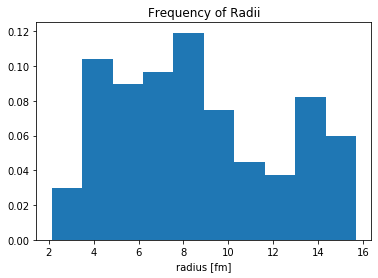

In [19]:
#lets look at the distribution of radii
plt.hist(radii, normed=True)
plt.xlabel('radius [fm]')
plt.title('Frequency of Radii')
plt.show()

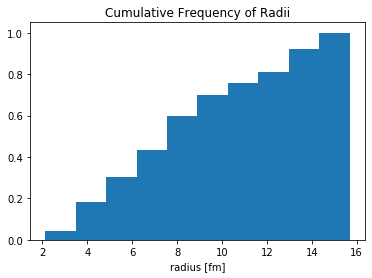

In [20]:
#lets look at the cumulative distribution of radii
plt.hist(radii,cumulative=1,density=True)
plt.xlabel('radius [fm]')
plt.title('Cumulative Frequency of Radii')
plt.show()

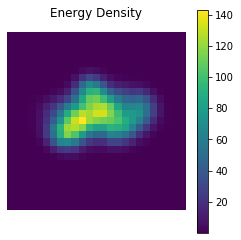

radius = 14.064924544


In [21]:
#lets look at an energy density 
choice = 10
mat = plt.matshow(e_profiles[choice])
cbar = plt.colorbar(mat)
plt.title("Energy Density")
plt.axis('off')
plt.show()
print("radius = " + str(radii[choice]))

In [22]:
#lets define our own global scaling function, that preserves the physics
#a larger energy density normalization -> larger radius
#other scalers provided by sklearn usually scale the pixel values independently
def global_scaler(X):
    X *= (1.0/X.max())
    return X

In [23]:
#Lets first try to train a model using only the energy density
#our features are the energy density profile, and 'labels' are the radii
X = e_profiles
y = radii

#reshape the features and targets to 2D array 
X = X.reshape((n_profiles, profile_shape[0]**2))

In [24]:
#use global scaler 
X_scaled = global_scaler(X)

#split into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=1, shuffle=False)

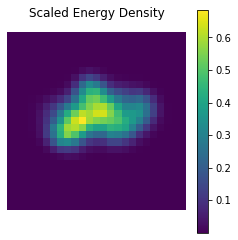

In [25]:
mat = plt.matshow(X_train[choice].reshape(profile_shape))
cbar = plt.colorbar(mat)
plt.title("Scaled Energy Density")
plt.axis('off')
plt.show()

Explained variance ratio = [0.82645056 0.03743894 0.03401354 0.02929082 0.02191725 0.00727096
 0.00632315 0.00481073 0.00427341 0.00340314 0.00315681 0.00298167
 0.00254353 0.00200589 0.00150183 0.00146494 0.00122387]
Singular Values = [42.0234407   8.94427058  8.52528844  7.91131988  6.84346771  3.94166005
  3.6757846   3.20618694  3.02183361  2.696641    2.59721223  2.52413875
  2.33131804  2.07031809  1.79140675  1.76926618  1.61715018]


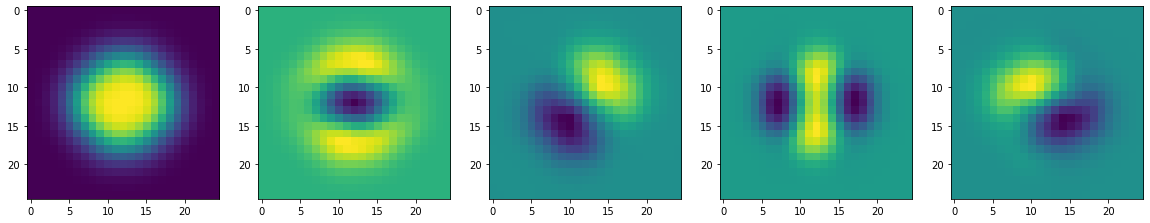

In [26]:
#first we can try PCA to reduce the degrees of freedom/dimensionality 
pca = PCA(0.99) #seek 99% of explained variance
pca.fit(X_train) #fit the transformation to only the training data
print("Explained variance ratio = " + str(pca.explained_variance_ratio_))  
print("Singular Values = " + str(pca.singular_values_))

#this will plot the Principal axes...
n_plots=5
fig, ax = plt.subplots(1,n_plots, figsize=(20,10))
for i in range(n_plots):
    ax[i].imshow(pca.components_[i].reshape(25,25))

### So we see that PCA is not doing something unreasonable, the first principal component looks like a round/gaussian-like profile, the 2nd one describes something like a dipole moment, etc... 

In [27]:
#transform the data with PCA
X_train_pc = pca.transform(X_train)
X_test_pc = pca.transform(X_test)
print("X_train.shape = " + str(X_train.shape))
print("X_train_pc.shape = " + str(X_train_pc.shape))

X_train.shape = (475, 625)
X_train_pc.shape = (475, 17)


(17,)
(17, 625)


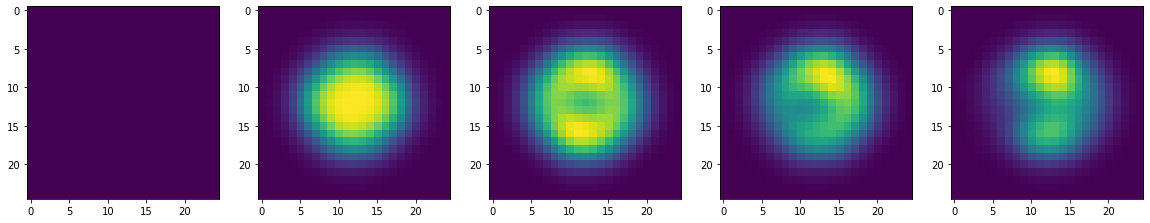

In [28]:
print(pca.singular_values_.shape)
print(pca.components_.shape)
fig, ax = plt.subplots(1,n_plots, figsize=(20,10))

#these are the 'eigen-images'
for i in range(n_plots):
    ax[i].imshow(pca.singular_values_.reshape(-1,1)[:i].T.dot(pca.components_[:i]).reshape(25,25))

### These are like the eigen-images of the transformation, each image can be decomposed as a linear combination of the images above

### Now, we can try to fit a supervised learning model to our data

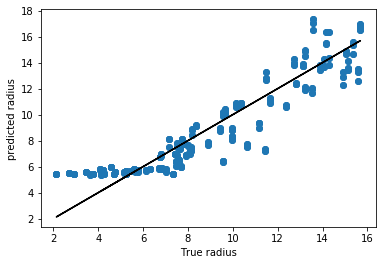

In [29]:
#A Linear Regression model
# Note, that this is the performance for the TRAINING set, not a testing set.
# We are asking the model to predict the values of points it was trained on...
lin_reg_model = LinearRegression().fit(X_train_pc, y_train)
lin_predictions = lin_reg_model.predict(X_train_pc) 
plt.scatter(y_train, lin_predictions)
plt.plot(y_train, y_train, color='black')
plt.xlabel('True radius')
plt.ylabel('predicted radius')
plt.show()

### Why did this go so terribly wrong? 
Well, it could be that PCA is seeing that the maximum of the pixel-value variance occurs near the center, which is true. But also, it could be that weighting the values of the energy density very high near the center and very low near the edges is bad for trying to predict the final radius...

### Instead of PCA, lets try to generate our own set of physical features which we believe are strong predictors of the radius

Consider a set of radial moments defined by 
$$ M_n \equiv \int r dr d\phi e(x,y) \hat{r}^n,$$
where $e(x,y)$ is the energy density in the transverse plane, and $\hat{r}$ is the distance from the coordinate origin scaled by some length scale $L$ to make it dimensionless. It is good to choose $L$ to be the radius of our spatial grid, for instance; then in this case, $\hat{r} <= 1$ and we expect that the moments might converge...
We see that, for instance $M_0$ is proportional to the total energy in the transverse plane

In [30]:
#lets define a function to find the n^th moment
#the pixel spacing in our images corresponds to 0.8 fm (originally 0.1 fm, we coarse grained by a factor of 8)
dx = 0.8 # dx = dy , square grid
#our total grid size is 25x25, so we can take for the `radius` (25 / 2) * dx
def compute_moment(mat, n):
    L = (mat.shape[0] - 1)/2 * dx
    temp = 0. 
    #the center is here
    center_idx = (mat.shape[0] - 1)//2
    for ix in range(mat.shape[0]):
        x = (ix - center_idx) * dx
        for iy in range(mat.shape[0]):
            y = (iy - center_idx) * dx
            r = np.sqrt(x**2. + y**2.)
            rn = r ** n
            temp += mat[ix, iy] * rn
    return temp * dx * dx / (L**n)

In [31]:
#now compute the moments for all the profiles
n_max = 5
profile_moments = np.zeros((n_profiles, n_max))
for i in range(n_profiles):
    mat = X_scaled[i, :].reshape(25, 25)
    for n in range(n_max):
        Mn = compute_moment(mat, n)
        profile_moments[i, n] = Mn

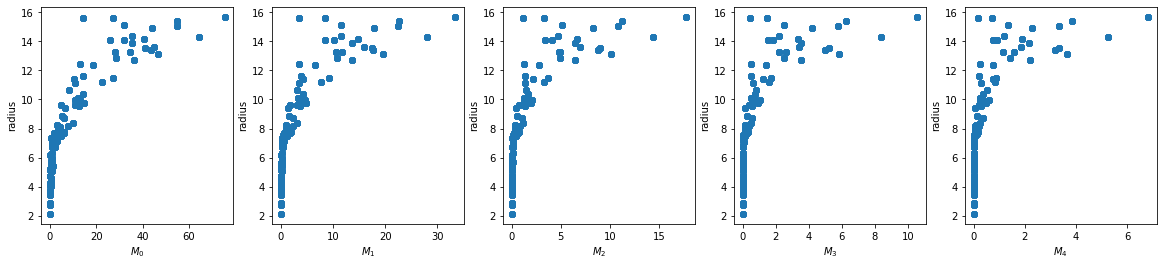

In [32]:
fig, ax = plt.subplots(1, n_max, figsize=(20,4))
for k in range(n_max):
    ax[k].scatter(profile_moments[:, k], y)
    ax[k].set_xlabel(r'$M_{:d}$'.format(k))
    ax[k].set_ylabel('radius')

### So it looks like our moments are converging, which is good, but also we see that they are correlated with the radius in a very non-linear way. Let's try a non-linear transformation of the moments...

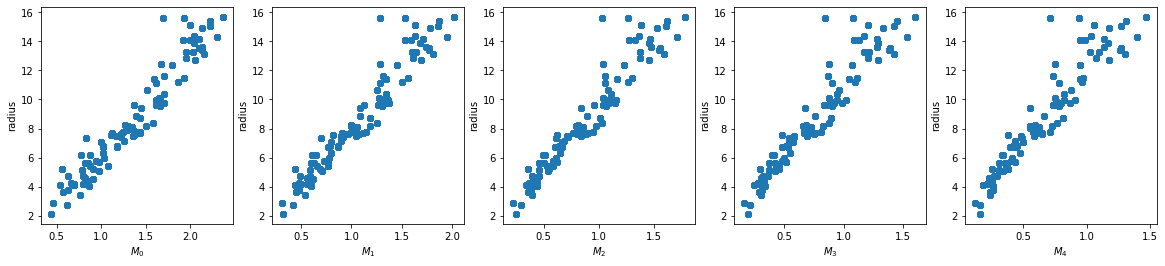

In [37]:
fig, ax = plt.subplots(1, n_max, figsize=(20,4))
power = 0.2 #why this power gives a good linear transformation is still a mystery to me...
for k in range(n_max):
    ax[k].scatter(profile_moments[:, k]**power, y)
    ax[k].set_xlabel(r'$M_{:d}$'.format(k))
    ax[k].set_ylabel('radius')

In [38]:
#nonlinear transformation of the moments
profile_moments_trans = profile_moments[:, :]**power

### now the transformed moments are our features, and the radii are the labels. We can try various supervised learning models and see how they perform...

In [39]:
X_train, X_test, y_train, y_test = train_test_split(profile_moments_trans, y, 
                                                    test_size = 0.2, random_state=1, shuffle=True)

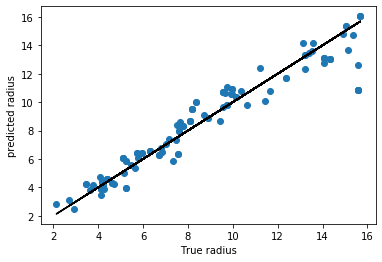

score = 0.9085659178590875
[  -13.01867175   283.67322892 -1011.18947602  1300.52676593
  -553.22864687]
0.4549568788173435


In [40]:
#Linear Regression
lin_reg_model = LinearRegression().fit(X_train, y_train)
lin_predictions = lin_reg_model.predict(X_test) 
plt.scatter(y_test, lin_predictions)
plt.plot(y_test, y_test, color='black')
plt.xlabel('True radius')
plt.ylabel('predicted radius')
plt.show()
print("score = " + str(lin_reg_model.score(X_test, y_test)))
print(str(lin_reg_model.coef_))
print(str(lin_reg_model.intercept_))

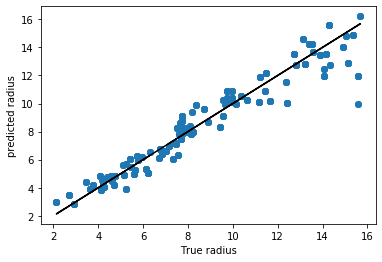

score = 0.881098636840358


In [41]:
#we can try Support Vector Machines for SVM Regression
svr_linear_model = svm.SVR(kernel='linear', gamma='auto', C=2.0, epsilon=0.1)
svr_linear_model.fit(X_train, y_train)
svr_linear_predictions = svr_linear_model.predict(X_train) 
plt.scatter(y_train, svr_linear_predictions)
plt.plot(y_train, y_train, color='black')
plt.xlabel('True radius')
plt.ylabel('predicted radius')
plt.show()
print("score = " + str(svr_linear_model.score(X_test, y_test)))

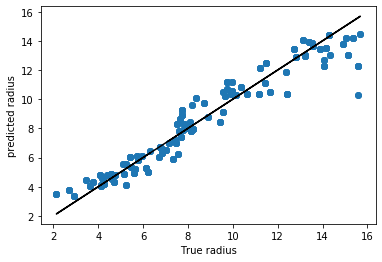

score = 0.8869355366946065


In [42]:
#SVM with RBF kernel
svr_rbf_model = svm.SVR(kernel='rbf', gamma = 'auto', C=1.0, epsilon=0.1)
svr_rbf_model.fit(X_train, y_train)
svr_rbf_predictions = svr_rbf_model.predict(X_train)
plt.scatter(y_train, svr_rbf_predictions)
plt.plot(y_train, y_train, color='black')
plt.xlabel('True radius')
plt.ylabel('predicted radius')
plt.show()
print("score = " + str(svr_rbf_model.score(X_test, y_test)))

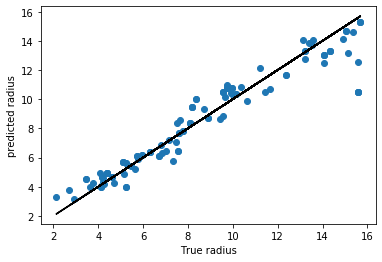

score = 0.9013691336897021


In [43]:
svr_poly_model = svm.SVR(kernel='poly', gamma='auto', degree=3, epsilon=.5,
               coef0=1)
svr_poly_model.fit(X_train, y_train)
svr_poly_predictions = svr_poly_model.predict(X_test)
plt.scatter(y_test, svr_poly_predictions)
plt.plot(y_test, y_test, color='black')
plt.xlabel('True radius')
plt.ylabel('predicted radius')
plt.show()
print("score = " + str(svr_poly_model.score(X_test, y_test)))

### Each of the models above perform reasonably well w/o tuning the hyper-parameters.

### To Do: explore different non-linear transformations of the moments, tuning of the hyper-parameters for each model above, and different non-linear kernels for each of the models. 

In [44]:
#try CNN
X_train = X_train.reshape(-1, n_max, 1, 1)
X_test = X_test.reshape(-1, n_max, 1, 1)

cnn_model = Sequential()
cnn_model.add(Conv2D(64, (3,1), input_shape=(n_max, 1, 1)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(1,1)))
cnn_model.add(Conv2D(64, (1,1)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(1,1)))
cnn_model.add(Flatten())
cnn_model.add(Dense(1))
cnn_model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
cnn_model.fit(X_train, y_train, batch_size=64, epochs=10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
475/475 [==============================] - 0s 528us/step - loss: 78.2456 - acc: 0.0000e+00
Epoch 2/10
475/475 [==============================] - 0s 54us/step - loss: 70.5781 - acc: 0.0000e+00
Epoch 3/10
475/475 [==============================] - 0s 57us/step - loss: 61.4381 - acc: 0.0000e+00
Epoch 4/10
475/475 [==============================] - 0s 56us/step - loss: 49.5383 - acc: 0.0000e+00
Epoch 5/10
475/475 [==============================] - 0s 53us/step - loss: 35.4492 - acc: 0.0000e+00
Epoch 6/10
475/475 [==============================] - 0s 50us/step - loss: 20.3920 - acc: 0.0000e+00
Epoch 7/10
475/475 [==============================] - 0s 44us/step - loss: 7.8640 - acc: 0.0000e+00
Epoch 8/10
475/475 [==============================] - 0s 54us/step - loss: 1.7809 - acc: 0.0000e+00
Epoch 9/10
475/475 [==============================] - 0s 34us/step - loss